## **ATP Maintenance Investigation**

By Garrett Roell

Tested on biodesign_3.7 kernel on jprime

**Import python packages**

In [2]:
import cobra
import sys
import matplotlib
from matplotlib import pyplot as plt

SourceDir = '../src'
sys.path.append(SourceDir)
from utils import *

**Load model**

In [3]:
file_name =  '../models/Ropacus_annotated_curated.xml'
model = cobra.io.read_sbml_model(file_name)

**Define measured uptake rates and growth rates**
<br>
From notebook D

In [4]:
phenol_uptake_rate = 1.352072 # mmol phenol / g dry cell weight / hr
phenol_growth_rate = 0.065488 # hr-1

glucose_uptake_rate = 3.582471 # mmol glucose / g dry cell weight / hr
glucose_growth_rate = 0.260195 # hr-1

**Run phenol FBA with many levels of ATP maintenance flux**

In [5]:
atp_growth_data = {}

# try every flux from 0 to 100 with a step of 10
for atp_maintenance_flux in range(0, 45, 5):
    # fix atp maintenance flux
    model.reactions.get_by_id('ATPM').lower_bound = atp_maintenance_flux
    model.reactions.get_by_id('ATPM').upper_bound = atp_maintenance_flux
    
    # run FBA
    phenol_fba_solution = FBA_pred(model, 'phenol', sub_uptake_rate=phenol_uptake_rate, verbose=False) 
    
    # save data pair of atp maintenance flux and growth rate
    atp_growth_data[atp_maintenance_flux] = phenol_fba_solution.objective_value
    
print(atp_growth_data)

{0: 0.15129066291786544, 5: 0.1329483777971082, 10: 0.11443198244704791, 15: 0.0959155870969876, 20: 0.07739919174692729, 25: 0.05888279639686696, 30: 0.040366401046806444, 35: 0.021850005696746146, 40: 0.0033336103466862065}


**Plot phenol growth rate vs. ATP maintenance flux**

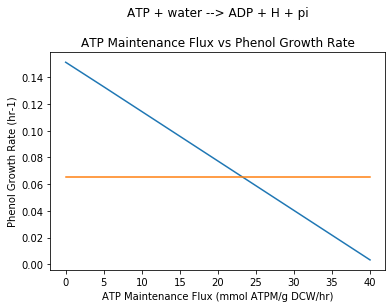

In [6]:
plt.plot(list(atp_growth_data.keys()), list(atp_growth_data.values()))
plt.plot([0, 40], [phenol_growth_rate, phenol_growth_rate])
plt.title('ATP + water --> ADP + H + pi\n\nATP Maintenance Flux vs Phenol Growth Rate')
plt.ylabel('Phenol Growth Rate (hr-1)')
plt.xlabel('ATP Maintenance Flux (mmol ATPM/g DCW/hr)')
plt.show()

**Run Flux Variability Analysis for Phenol ATP maintenance flux value**

In [34]:
with model:
    # reset atm maintenance bounds
    model.reactions.get_by_id('ATPM').lower_bound = 0
    model.reactions.get_by_id('ATPM').upper_bound = 1000
    
    # set up objective function
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Phenol').upper_bound = phenol_growth_rate

    # set up medium
    medium = model.medium 
    medium = {key:1000 for (key,value) in model.medium.items()}
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    model.reactions.get_by_id('Growth').upper_bound = 0
    model.reactions.get_by_id('Growth').lower_bound = 0

    #remove all non-phenol carbon sources:
    medium["EX_glc__D_e"] = 0
    medium['EX_guaiacol_e'] = 0
    medium['EX_vanlt_e'] = 0
    medium['EX_tag'] = 0
    medium["EX_phenol_e"] = phenol_uptake_rate

    model.medium = medium    
    display(model.medium)
    
    results = cobra.flux_analysis.flux_variability_analysis(model, ['ATPM'], fraction_of_optimum=1)
    display(results)

{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_phenol_e': 1.352072}

,minimum,maximum
ATPM,0.0,23.216391


**Run glucose FBA with many levels of ATP maintenance flux**

In [6]:
atp_growth_data = {}

# try every flux from 0 to 100 with a step of 10
for atp_maintenance_flux in range(0, 140, 5):
    # fix atp maintenance flux
    model.reactions.get_by_id('ATPM').lower_bound = atp_maintenance_flux
    model.reactions.get_by_id('ATPM').upper_bound = atp_maintenance_flux
    
    # run FBA
    glucose_fba_solution = FBA_pred(model, 'glucose', sub_uptake_rate=glucose_uptake_rate, verbose=False) 
    
    # save data pair of atp maintenance flux and growth rate
    atp_growth_data[atp_maintenance_flux] = glucose_fba_solution.objective_value
    
print(atp_growth_data)

{0: 0.4807436104890257, 5: 0.46308659715319156, 10: 0.4454295838173572, 15: 0.4277725704815207, 20: 0.4101155571456858, 25: 0.39245854380985096, 30: 0.37480153047401776, 35: 0.3571445171381828, 40: 0.33948750380234805, 45: 0.32183049046651474, 50: 0.3041734771306799, 55: 0.28651646379484674, 60: 0.2688594504590118, 65: 0.2512024371231769, 70: 0.23354542378734364, 75: 0.21588841045150883, 80: 0.1982313971156739, 85: 0.1805743837798391, 90: 0.16291737044400426, 95: 0.1452603571081693, 100: 0.1276033437723344, 105: 0.10994633043649966, 110: 0.09228931710066476, 115: 0.07463230376483003, 120: 0.05697529042899511, 125: 0.039318277093160395, 130: 0.02166126375732546, 135: 0.0040042504214905334}


**Plot glucose growth rate vs. ATP maintenance flux**

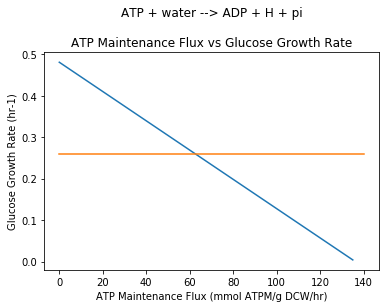

In [7]:
plt.plot(list(atp_growth_data.keys()), list(atp_growth_data.values()))
plt.plot([0, 140], [glucose_growth_rate, glucose_growth_rate])
plt.title('ATP + water --> ADP + H + pi\n\nATP Maintenance Flux vs Glucose Growth Rate')
plt.ylabel('Glucose Growth Rate (hr-1)')
plt.xlabel('ATP Maintenance Flux (mmol ATPM/g DCW/hr)')
plt.show()

**Run Flux Variability Analysis for Phenol ATP maintenance flux value**

In [36]:
with model:
    # reset atm maintenance bounds
    model.reactions.get_by_id('ATPM').lower_bound = 0
    model.reactions.get_by_id('ATPM').upper_bound = 1000
    
    # set up objective function
    model.objective = 'Growth_Glucose'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = glucose_growth_rate

    # set up medium
    medium = model.medium 
    medium = {key:1000 for (key,value) in model.medium.items()}
    model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
    model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
    model.reactions.get_by_id('Growth').upper_bound = 0
    model.reactions.get_by_id('Growth').lower_bound = 0

    #remove all non-glucose carbon sources:
    medium["EX_glc__D_e"] = glucose_uptake_rate
    medium['EX_guaiacol_e'] = 0
    medium['EX_vanlt_e'] = 0
    medium['EX_tag'] = 0
    medium["EX_phenol_e"] = 0

    model.medium = medium    
    display(model.medium)
    
    results = cobra.flux_analysis.flux_variability_analysis(model, ['ATPM'], fraction_of_optimum=1)
    display(results)

{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 3.582471,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0}

,minimum,maximum
ATPM,0.0,62.453544


**P/O ratio investigation**

In [8]:
for r in model.metabolites.get_by_id('q8_c').reactions:
    print(r)

NADH5: h_c + nadh_c + q8_c --> nad_c + q8h2_c
L_LACD2: lac__L_c + q8_c --> pyr_c + q8h2_c
QMO2: 2.0 o2_c + q8h2_c --> 2.0 h_c + 2.0 o2s_c + q8_c
POX: h2o_c + pyr_c + q8_c --> ac_c + co2_c + q8h2_c
GAD2ktpp: glcn_p + q8_c <=> 2dhglcn_p + q8h2_c
TETDHpp3: q8h2_c + tet_p --> 2.0 h_p + q8_c + 2.0 tsul_p
MDH2: mal__L_c + q8_c --> oaa_c + q8h2_c
HYD1pp: h2_c + 2.0 h_c + q8_c --> 2.0 h_p + q8h2_c
GLCDpp: glc__D_p + h2o_p + q8_c --> glcn_p + h_p + q8h2_c
LDH_D2: lac__D_c + q8_c --> pyr_c + q8h2_c
NADPHQR2: h_c + nadph_c + q8_c --> nadp_c + q8h2_c
DHORD2: dhor__S_c + q8_c --> orot_c + q8h2_c
TTONR2pp: q8h2_c + tton_e --> 4.0 h_c + q8_c + so3_e + tsul_e
GLYCTO2: glyclt_c + q8_c --> glx_c + q8h2_c
CYTBDpp: 2.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 2.0 h_p + q8_c
G3PD5: glyc3p_c + q8_c --> dhap_c + q8h2_c
CYTBD: 2.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 2.0 h_e + q8_c


In [9]:
for r in model.metabolites.get_by_id('q8h2_c').reactions:
    print(r)

NADH5: h_c + nadh_c + q8_c --> nad_c + q8h2_c
L_LACD2: lac__L_c + q8_c --> pyr_c + q8h2_c
QMO2: 2.0 o2_c + q8h2_c --> 2.0 h_c + 2.0 o2s_c + q8_c
POX: h2o_c + pyr_c + q8_c --> ac_c + co2_c + q8h2_c
GAD2ktpp: glcn_p + q8_c <=> 2dhglcn_p + q8h2_c
TETDHpp3: q8h2_c + tet_p --> 2.0 h_p + q8_c + 2.0 tsul_p
MDH2: mal__L_c + q8_c --> oaa_c + q8h2_c
HYD1pp: h2_c + 2.0 h_c + q8_c --> 2.0 h_p + q8h2_c
GLCDpp: glc__D_p + h2o_p + q8_c --> glcn_p + h_p + q8h2_c
LDH_D2: lac__D_c + q8_c --> pyr_c + q8h2_c
NADPHQR2: h_c + nadph_c + q8_c --> nadp_c + q8h2_c
DHORD2: dhor__S_c + q8_c --> orot_c + q8h2_c
TTONR2pp: q8h2_c + tton_e --> 4.0 h_c + q8_c + so3_e + tsul_e
GLYCTO2: glyclt_c + q8_c --> glx_c + q8h2_c
CYTBDpp: 2.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 2.0 h_p + q8_c
G3PD5: glyc3p_c + q8_c --> dhap_c + q8h2_c
CYTBD: 2.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 2.0 h_e + q8_c


In [16]:
model.reactions.get_by_id('ATPM').bounds

(135, 135)